In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook has been created from the last iteration of 

  RunModel_Tracks_to_KDE_Testing_Skipper_14November2020_iter_1A
  
and has modified to
<ol>
    <li>  use a different loss function (kde_loss_Ba)</li>
    <li>  use much more training data (using Will's files)</li>
</ol>
    

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Feb 16 08:26:19 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   36C    P2    25W / 250W |   7067MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   32C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 525

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## Iter 2A ended with training cost = 3.94; validation 3.7 - 3.8
## Iter 2A2 ended with training cost = ~3.65, validation cost ~ .45
##  for Iter2A3, try increasing the l.r. from 1e-5 to 3e-5 as the decrease
##  in training cost was almost monotonic
##  Iter2A3 costs jumped and started to come down;  start with Iter2A2 again
##   and use an intermediate l.r. = 2e-5
##  Iter2A4 costs also jumped, although not so much for validation
##  In any case, let's revert to lr. = 1e-5 for the moment
folder = '16February_Skipper_iter2A6_525epochs_2em5_4xwill'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 1e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_kdeB_Ellipsoids import load_prebuilt_dataset


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_Skipper has 12 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_Skipper as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=59, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=59, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=59, out_features=4000, bias=True)


Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()


output =  ML/16February_Skipper_iter2A6_525epochs_2em5_4xwill
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12.weight
index, k =   23    layer12.bias


In [14]:
##old_file = '15November_testing_Skipper_first_learning_iter_2A_1000epochs_1em5'
##old_file = '15November_testing_Skipper_first_learning_iter_2B_1000epochs_5em6'
##old_file = '15November_testing_Skipper_first_learning_iter_3B_1000epochs_3em6'

## for 15February_Skipper_iter2A5_400epochs_2em5_4xwill use iter 394 as it was something of a lcao;
## minimum in validation cost, and we will use a lower learning rate for the next iteration
old_file = '15February_Skipper_iter2A5_400epochs_2em5_4xwill'
old_name = old_file
iter_name = "394"
dict_name = "ML/" + old_file + "/" + old_name + "_" + iter_name + ".pyt"
pretrained_dict = torch.load(dict_name)


print(" ")
print("  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 

##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

 
  for pretrained_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12.weight
index, k =   23    layer12.bias
pretrained_dict iterated


<All keys matched successfully>

In [15]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [16]:

## Training dataset. You can put as many files here as desired.

## 210109 let's use some of Will's toy MC for training rather than the 20K sample I've been using

##train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
'''train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                                  '/share/lazy/will/data/June30_2020_80k_2.h5',
                                  '/share/lazy/will/data/June30_2020_80k_3.h5',
                                  '/share/lazy/will/data/June30_2020_80k_4.h5',
                                ##  '/share/lazy/will/data/June30_2020_80k_5.h5',
                                ##  '/share/lazy/will/data/June30_2020_80k_6.h5',
                                ##  '/share/lazy/will/data/June30_2020_80k_7.h5',
                             batch_size=batch_size,
                           )
'''

##  16 February 2021
##  use Will's pre-built data sets; loading them is much faster; they also
##  require less CPU memory; it seems likely we can use all 7 rather than 4
##  even on goofy; 
##  stick with 4 for the moment
train_loader = load_prebuilt_dataset(batch_size = batch_size, num_files=4)
    
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            ##slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


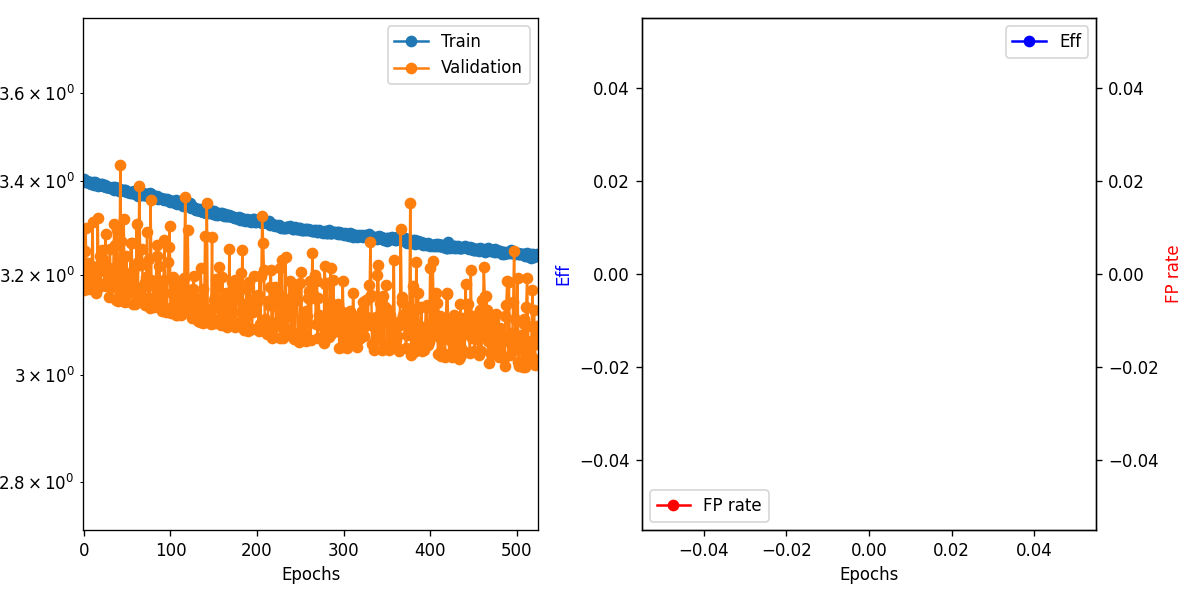

In [17]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [18]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 5000, val = 313


Number of batches: train = 5000, val = 313


Epoch 0: train=3.40461, val=3.1692, took 165.69 s


Epoch 1: train=3.39897, val=3.25033, took 159.89 s


Epoch 2: train=3.3997, val=3.29879, took 164.09 s


Epoch 3: train=3.39854, val=3.19507, took 161.16 s


Epoch 4: train=3.40026, val=3.19178, took 160.6 s


Epoch 5: train=3.39736, val=3.226, took 161.34 s


Epoch 6: train=3.39563, val=3.17089, took 161.22 s


Epoch 7: train=3.39841, val=3.17553, took 160.62 s


Epoch 8: train=3.39428, val=3.17968, took 161.29 s


Epoch 9: train=3.39651, val=3.21968, took 160.72 s


Epoch 10: train=3.39772, val=3.31255, took 159.97 s


Epoch 11: train=3.39552, val=3.17244, took 160.2 s


Epoch 12: train=3.39279, val=3.17172, took 160.6 s


Epoch 13: train=3.39723, val=3.20001, took 159.87 s


Epoch 14: train=3.39698, val=3.16281, took 161.5 s


Epoch 15: train=3.39431, val=3.18473, took 159.17 s


Epoch 16: train=3.38949, val=3.32027, took 160.2 s


Epoch 17: train=3.39176, val=3.17592, took 160.8 s


Epoch 18: train=3.39131, val=3.23983, took 160.48 s


Epoch 19: train=3.39189, val=3.17916, took 160.48 s


Epoch 20: train=3.3935, val=3.21293, took 160.25 s


Epoch 21: train=3.39463, val=3.25205, took 160.5 s


Epoch 22: train=3.38906, val=3.23401, took 160.06 s


Epoch 23: train=3.38913, val=3.20815, took 161.17 s


Epoch 24: train=3.39184, val=3.2202, took 160.74 s


Epoch 25: train=3.38736, val=3.28505, took 160.68 s


Epoch 26: train=3.38658, val=3.17641, took 160.57 s


Epoch 27: train=3.38754, val=3.18699, took 161.05 s


Epoch 28: train=3.38646, val=3.19277, took 160.23 s


Epoch 29: train=3.38625, val=3.15482, took 160.24 s


Epoch 30: train=3.38566, val=3.25325, took 160.53 s


Epoch 31: train=3.38456, val=3.18373, took 160.68 s


Epoch 32: train=3.38494, val=3.17474, took 161.59 s


Epoch 33: train=3.38606, val=3.20502, took 159.88 s


Epoch 34: train=3.38656, val=3.21388, took 160.98 s


Epoch 35: train=3.38182, val=3.3069, took 161.98 s


Epoch 36: train=3.38773, val=3.26226, took 161.61 s


Epoch 37: train=3.38393, val=3.14935, took 160.76 s


Epoch 38: train=3.38206, val=3.29445, took 161.77 s


Epoch 39: train=3.38552, val=3.14733, took 161.93 s


Epoch 40: train=3.38382, val=3.19176, took 162.27 s


Epoch 41: train=3.37827, val=3.15116, took 161.16 s


Epoch 42: train=3.38044, val=3.4348, took 161.28 s


Epoch 43: train=3.38071, val=3.27035, took 160.15 s


Epoch 44: train=3.38055, val=3.15415, took 161.59 s


Epoch 45: train=3.37984, val=3.14756, took 160.59 s


Epoch 46: train=3.37795, val=3.31888, took 160.92 s


Epoch 47: train=3.38025, val=3.14466, took 160.72 s


Epoch 48: train=3.37972, val=3.19189, took 161.11 s


Epoch 49: train=3.37787, val=3.23957, took 161.04 s


Epoch 50: train=3.37668, val=3.16043, took 162.23 s


Epoch 51: train=3.37599, val=3.18045, took 161.74 s


Epoch 52: train=3.37595, val=3.20046, took 162.68 s


Epoch 53: train=3.37482, val=3.16738, took 160.86 s


Epoch 54: train=3.37679, val=3.26609, took 161.34 s


Epoch 55: train=3.37489, val=3.26741, took 162.9 s


Epoch 56: train=3.37632, val=3.2071, took 161.55 s


Epoch 57: train=3.37422, val=3.14033, took 162.54 s


Epoch 58: train=3.37816, val=3.21379, took 161.29 s


Epoch 59: train=3.37133, val=3.14051, took 161.64 s


Epoch 60: train=3.37358, val=3.1606, took 161.1 s


Epoch 61: train=3.37408, val=3.30786, took 160.73 s


Epoch 62: train=3.37307, val=3.15311, took 160.4 s


Epoch 63: train=3.36832, val=3.22621, took 160.5 s


Epoch 64: train=3.3741, val=3.38959, took 160.26 s


Epoch 65: train=3.37164, val=3.22562, took 160.64 s


Epoch 66: train=3.37399, val=3.22043, took 160.57 s


Epoch 67: train=3.36919, val=3.25517, took 161.34 s


Epoch 68: train=3.37515, val=3.1765, took 160.88 s


Epoch 69: train=3.36933, val=3.15282, took 160.37 s


Epoch 70: train=3.37041, val=3.13888, took 161.24 s


Epoch 71: train=3.37054, val=3.18602, took 160.62 s


Epoch 72: train=3.36986, val=3.19672, took 160.46 s


Epoch 73: train=3.37152, val=3.29005, took 161.02 s


Epoch 74: train=3.37194, val=3.14346, took 160.78 s


Epoch 75: train=3.36619, val=3.23294, took 160.36 s


Epoch 76: train=3.37331, val=3.13262, took 161.17 s


Epoch 77: train=3.36792, val=3.35874, took 160.25 s


Epoch 78: train=3.37119, val=3.19008, took 160.54 s


Epoch 79: train=3.36574, val=3.18711, took 161.09 s


Epoch 80: train=3.36599, val=3.15197, took 160.49 s


Epoch 81: train=3.36666, val=3.13375, took 160.97 s


Epoch 82: train=3.36697, val=3.13865, took 160.82 s


Epoch 83: train=3.36498, val=3.17227, took 160.78 s


Epoch 84: train=3.36781, val=3.23935, took 160.11 s


Epoch 85: train=3.36498, val=3.26368, took 160.81 s


Epoch 86: train=3.36032, val=3.1345, took 161.03 s


Epoch 87: train=3.36307, val=3.21817, took 160.36 s


Epoch 88: train=3.36426, val=3.14577, took 161.51 s


Epoch 89: train=3.36421, val=3.17215, took 160.37 s


Epoch 90: train=3.36199, val=3.12725, took 161.17 s


Epoch 91: train=3.36206, val=3.16428, took 161.72 s


Epoch 92: train=3.36181, val=3.19058, took 161.53 s


Epoch 93: train=3.35923, val=3.27405, took 161.26 s


Epoch 94: train=3.36133, val=3.13007, took 160.23 s


Epoch 95: train=3.35869, val=3.1246, took 161.29 s


Epoch 96: train=3.36129, val=3.12771, took 160.98 s


Epoch 97: train=3.35859, val=3.22614, took 160.55 s


Epoch 98: train=3.35813, val=3.25782, took 161.16 s


Epoch 99: train=3.35563, val=3.30209, took 160.9 s


Epoch 100: train=3.35774, val=3.13262, took 161.28 s


Epoch 101: train=3.35585, val=3.12333, took 164.33 s


Epoch 102: train=3.35619, val=3.16372, took 166.57 s


Epoch 103: train=3.35506, val=3.19664, took 166.72 s


Epoch 104: train=3.3536, val=3.13023, took 166.23 s


Epoch 105: train=3.35255, val=3.13234, took 166.73 s


Epoch 106: train=3.35914, val=3.11923, took 169.5 s


Epoch 107: train=3.35352, val=3.15622, took 167.61 s


Epoch 108: train=3.35058, val=3.1193, took 169.17 s


Epoch 109: train=3.35392, val=3.18105, took 166.55 s


Epoch 110: train=3.35173, val=3.182, took 164.12 s


Epoch 111: train=3.35253, val=3.17955, took 161.82 s


Epoch 112: train=3.35408, val=3.11751, took 160.97 s


Epoch 113: train=3.34972, val=3.18673, took 160.49 s


Epoch 114: train=3.34866, val=3.14689, took 161.54 s


Epoch 115: train=3.34693, val=3.13552, took 159.81 s


Epoch 116: train=3.34822, val=3.19443, took 159.03 s


Epoch 117: train=3.34892, val=3.36578, took 159.12 s


Epoch 118: train=3.35347, val=3.13119, took 160.05 s


Epoch 119: train=3.34879, val=3.14098, took 159.49 s


Epoch 120: train=3.346, val=3.29379, took 159.6 s


Epoch 121: train=3.34813, val=3.12257, took 159.39 s


Epoch 122: train=3.34627, val=3.14525, took 159.63 s


Epoch 123: train=3.35308, val=3.12822, took 160.6 s


Epoch 124: train=3.34136, val=3.16817, took 160.63 s


Epoch 125: train=3.34493, val=3.11141, took 160.1 s


Epoch 126: train=3.34259, val=3.17093, took 160.18 s


Epoch 127: train=3.34153, val=3.1979, took 160.19 s


Epoch 128: train=3.34186, val=3.11944, took 161.12 s


Epoch 129: train=3.33758, val=3.15335, took 158.93 s


Epoch 130: train=3.33701, val=3.11339, took 159.29 s


Epoch 131: train=3.33959, val=3.14494, took 158.84 s


Epoch 132: train=3.33758, val=3.10562, took 159.41 s


Epoch 133: train=3.33964, val=3.11594, took 161.87 s


Epoch 134: train=3.33455, val=3.10461, took 161.24 s


Epoch 135: train=3.3359, val=3.2144, took 161.43 s


Epoch 136: train=3.34053, val=3.14259, took 160.16 s


Epoch 137: train=3.33622, val=3.17199, took 158.97 s


Epoch 138: train=3.33313, val=3.10193, took 158.97 s


Epoch 139: train=3.33247, val=3.13264, took 162.92 s


Epoch 140: train=3.33308, val=3.28278, took 158.75 s


Epoch 141: train=3.32989, val=3.12249, took 162.65 s


Epoch 142: train=3.33179, val=3.35291, took 159.22 s


Epoch 143: train=3.33588, val=3.12962, took 159.75 s


Epoch 144: train=3.33225, val=3.11577, took 159.1 s


Epoch 145: train=3.33024, val=3.10463, took 158.74 s


Epoch 146: train=3.33684, val=3.10339, took 159.19 s


Epoch 147: train=3.3337, val=3.10006, took 159.34 s


Epoch 148: train=3.33309, val=3.28022, took 160.99 s


Epoch 149: train=3.32817, val=3.10251, took 160.92 s


Epoch 150: train=3.33542, val=3.14918, took 159.34 s


Epoch 151: train=3.32979, val=3.1032, took 160.52 s


Epoch 152: train=3.3281, val=3.15553, took 159.73 s


Epoch 153: train=3.3264, val=3.19098, took 161.11 s


Epoch 154: train=3.33111, val=3.17549, took 160.17 s


Epoch 155: train=3.32726, val=3.13271, took 159.52 s


Epoch 156: train=3.32968, val=3.21705, took 159.55 s


Epoch 157: train=3.33145, val=3.1121, took 159.39 s


Epoch 158: train=3.32916, val=3.09771, took 160.31 s


Epoch 159: train=3.32773, val=3.1036, took 159.59 s


Epoch 160: train=3.32994, val=3.19538, took 160.96 s


Epoch 161: train=3.32674, val=3.1075, took 159.35 s


Epoch 162: train=3.32399, val=3.09831, took 159.86 s


Epoch 163: train=3.32786, val=3.12819, took 159.49 s


Epoch 164: train=3.32482, val=3.164, took 160.62 s


Epoch 165: train=3.32394, val=3.09466, took 160.23 s


Epoch 166: train=3.32566, val=3.16148, took 160.02 s


Epoch 167: train=3.32427, val=3.09632, took 159.31 s


Epoch 168: train=3.32568, val=3.25527, took 159.69 s


Epoch 169: train=3.32435, val=3.10576, took 159.53 s


Epoch 170: train=3.32348, val=3.09942, took 159.42 s


Epoch 171: train=3.32217, val=3.18461, took 159.32 s


Epoch 172: train=3.32262, val=3.15907, took 159.21 s


Epoch 173: train=3.32313, val=3.1048, took 159.76 s


Epoch 174: train=3.32052, val=3.19028, took 159.78 s


Epoch 175: train=3.31994, val=3.09508, took 159.4 s


Epoch 176: train=3.32056, val=3.18221, took 159.42 s


Epoch 177: train=3.31922, val=3.15584, took 161.08 s


Epoch 178: train=3.31953, val=3.18108, took 162.57 s


Epoch 179: train=3.32169, val=3.10153, took 159.81 s


Epoch 180: train=3.31582, val=3.0989, took 161.3 s


Epoch 181: train=3.31737, val=3.20457, took 160.64 s


Epoch 182: train=3.32013, val=3.12366, took 161.36 s


Epoch 183: train=3.31506, val=3.25153, took 161.43 s


Epoch 184: train=3.31838, val=3.14102, took 158.55 s


Epoch 185: train=3.31739, val=3.089, took 160.77 s


Epoch 186: train=3.31314, val=3.09837, took 159.22 s


Epoch 187: train=3.31691, val=3.11367, took 165.68 s


Epoch 188: train=3.31743, val=3.17221, took 158.06 s


Epoch 189: train=3.31585, val=3.08721, took 161.17 s


Epoch 190: train=3.31303, val=3.08819, took 158.49 s


Epoch 191: train=3.31666, val=3.18512, took 158.98 s


Epoch 192: train=3.31389, val=3.12928, took 160.05 s


Epoch 193: train=3.31086, val=3.14058, took 159.75 s


Epoch 194: train=3.31675, val=3.08977, took 158.4 s


Epoch 195: train=3.31765, val=3.12412, took 160.11 s


Epoch 196: train=3.31602, val=3.19884, took 159.5 s


Epoch 197: train=3.31731, val=3.13057, took 160.07 s


Epoch 198: train=3.31159, val=3.15336, took 159.85 s


Epoch 199: train=3.31166, val=3.13963, took 159.85 s


Epoch 200: train=3.31558, val=3.14375, took 160.63 s


Epoch 201: train=3.31521, val=3.15863, took 160.47 s


Epoch 202: train=3.31559, val=3.08541, took 159.49 s


Epoch 203: train=3.31643, val=3.19796, took 160.07 s


Epoch 204: train=3.31203, val=3.10101, took 159.3 s


Epoch 205: train=3.31246, val=3.19774, took 159.61 s


Epoch 206: train=3.3089, val=3.32515, took 158.43 s


Epoch 207: train=3.31119, val=3.26719, took 161.02 s


Epoch 208: train=3.31429, val=3.21046, took 158.73 s


Epoch 209: train=3.31288, val=3.1099, took 158.21 s


Epoch 210: train=3.31084, val=3.09621, took 159.82 s


Epoch 211: train=3.30965, val=3.10518, took 159.07 s


Epoch 212: train=3.31066, val=3.08124, took 157.99 s


Epoch 213: train=3.31039, val=3.14691, took 161.77 s


Epoch 214: train=3.31345, val=3.13782, took 158.45 s


Epoch 215: train=3.30571, val=3.17456, took 160.62 s


Epoch 216: train=3.30683, val=3.21131, took 160.33 s


Epoch 217: train=3.30746, val=3.07313, took 160.6 s


Epoch 218: train=3.30502, val=3.09128, took 158.95 s


Epoch 219: train=3.30451, val=3.16976, took 156.12 s


Epoch 220: train=3.30445, val=3.15692, took 157.25 s


Epoch 221: train=3.30362, val=3.17546, took 160.14 s


Epoch 222: train=3.30556, val=3.09953, took 159.86 s


Epoch 223: train=3.30349, val=3.13661, took 159.35 s


Epoch 224: train=3.30212, val=3.10634, took 160.15 s


Epoch 225: train=3.30471, val=3.15938, took 159.55 s


Epoch 226: train=3.30095, val=3.21467, took 159.0 s


Epoch 227: train=3.30011, val=3.07257, took 160.91 s


Epoch 228: train=3.29912, val=3.14147, took 158.19 s


Epoch 229: train=3.30108, val=3.23216, took 160.62 s


Epoch 230: train=3.29951, val=3.07227, took 159.13 s


Epoch 231: train=3.29837, val=3.11745, took 158.05 s


Epoch 232: train=3.29829, val=3.0924, took 159.43 s


Epoch 233: train=3.29875, val=3.23802, took 157.83 s


Epoch 234: train=3.30137, val=3.11701, took 160.34 s


Epoch 235: train=3.3005, val=3.07903, took 158.56 s


Epoch 236: train=3.30141, val=3.11682, took 158.18 s


Epoch 237: train=3.30066, val=3.1509, took 159.67 s


Epoch 238: train=3.30314, val=3.18743, took 158.75 s


Epoch 239: train=3.29934, val=3.08727, took 161.7 s


Epoch 240: train=3.29919, val=3.08043, took 159.05 s


Epoch 241: train=3.29768, val=3.1526, took 159.07 s


Epoch 242: train=3.29699, val=3.18136, took 157.57 s


Epoch 243: train=3.29931, val=3.0707, took 157.62 s


Epoch 244: train=3.30006, val=3.16035, took 158.61 s


Epoch 245: train=3.29628, val=3.17021, took 158.69 s


Epoch 246: train=3.29556, val=3.14876, took 158.96 s


Epoch 247: train=3.29656, val=3.08215, took 159.88 s


Epoch 248: train=3.29966, val=3.071, took 158.55 s


Epoch 249: train=3.29627, val=3.06485, took 160.45 s


Epoch 250: train=3.29927, val=3.18417, took 159.55 s


Epoch 251: train=3.295, val=3.20655, took 159.75 s


Epoch 252: train=3.294, val=3.07755, took 158.78 s


Epoch 253: train=3.29345, val=3.06771, took 160.53 s


Epoch 254: train=3.29554, val=3.08492, took 159.36 s


Epoch 255: train=3.29641, val=3.10245, took 159.74 s


Epoch 256: train=3.29354, val=3.06685, took 160.36 s


Epoch 257: train=3.29598, val=3.12661, took 161.84 s


Epoch 258: train=3.29398, val=3.11736, took 159.69 s


Epoch 259: train=3.29598, val=3.15239, took 158.83 s


Epoch 260: train=3.29406, val=3.16624, took 159.52 s


Epoch 261: train=3.29475, val=3.18753, took 158.5 s


Epoch 262: train=3.29458, val=3.06902, took 159.18 s


Epoch 263: train=3.2925, val=3.17148, took 159.1 s


Epoch 264: train=3.29207, val=3.24626, took 159.57 s


Epoch 265: train=3.29188, val=3.16184, took 159.75 s


Epoch 266: train=3.29435, val=3.15262, took 159.41 s


Epoch 267: train=3.29223, val=3.19998, took 158.31 s


Epoch 268: train=3.29504, val=3.09946, took 158.05 s


Epoch 269: train=3.29051, val=3.18765, took 158.66 s


Epoch 270: train=3.29048, val=3.0722, took 159.08 s


Epoch 271: train=3.29324, val=3.15294, took 159.44 s


Epoch 272: train=3.29382, val=3.11761, took 161.21 s


Epoch 273: train=3.2923, val=3.10103, took 155.23 s


Epoch 274: train=3.28998, val=3.11038, took 157.78 s


Epoch 275: train=3.29015, val=3.07477, took 159.39 s


Epoch 276: train=3.28884, val=3.09445, took 158.59 s


Epoch 277: train=3.28957, val=3.0629, took 161.21 s


Epoch 278: train=3.29223, val=3.21913, took 160.3 s


Epoch 279: train=3.29061, val=3.18112, took 159.46 s


Epoch 280: train=3.28755, val=3.1021, took 160.19 s


Epoch 281: train=3.28785, val=3.18279, took 159.52 s


Epoch 282: train=3.28896, val=3.11762, took 159.72 s


Epoch 283: train=3.29462, val=3.074, took 162.25 s


Epoch 284: train=3.28714, val=3.09209, took 158.4 s


Epoch 285: train=3.28735, val=3.21433, took 161.58 s


Epoch 286: train=3.28842, val=3.08054, took 155.76 s


Epoch 287: train=3.28861, val=3.09772, took 158.02 s


Epoch 288: train=3.29112, val=3.18875, took 158.49 s


Epoch 289: train=3.28921, val=3.13784, took 159.02 s


Epoch 290: train=3.28872, val=3.08695, took 160.23 s


Epoch 291: train=3.29086, val=3.13687, took 159.15 s


Epoch 292: train=3.28773, val=3.08641, took 155.82 s


Epoch 293: train=3.28526, val=3.12034, took 159.23 s


Epoch 294: train=3.28944, val=3.14056, took 160.63 s


Epoch 295: train=3.28955, val=3.05333, took 157.66 s


Epoch 296: train=3.28657, val=3.09968, took 158.71 s


Epoch 297: train=3.2891, val=3.12716, took 158.88 s


Epoch 298: train=3.28725, val=3.05487, took 156.89 s


Epoch 299: train=3.28605, val=3.1885, took 154.94 s


Epoch 300: train=3.28638, val=3.08671, took 161.69 s


Epoch 301: train=3.28349, val=3.10526, took 157.25 s


Epoch 302: train=3.2876, val=3.12016, took 157.49 s


Epoch 303: train=3.28357, val=3.07173, took 158.87 s


Epoch 304: train=3.28285, val=3.05193, took 159.67 s


Epoch 305: train=3.28644, val=3.06665, took 158.0 s


Epoch 306: train=3.28069, val=3.06113, took 157.87 s


Epoch 307: train=3.28714, val=3.12694, took 158.15 s


Epoch 308: train=3.28665, val=3.08225, took 158.8 s


Epoch 309: train=3.28323, val=3.10706, took 158.2 s


Epoch 310: train=3.28496, val=3.09623, took 158.91 s


Epoch 311: train=3.28023, val=3.16364, took 158.77 s


Epoch 312: train=3.28333, val=3.11677, took 158.33 s


Epoch 313: train=3.28126, val=3.06033, took 160.33 s


Epoch 314: train=3.28372, val=3.0996, took 159.17 s


Epoch 315: train=3.28012, val=3.07113, took 158.0 s


Epoch 316: train=3.2823, val=3.05461, took 158.08 s


Epoch 317: train=3.28241, val=3.10078, took 156.64 s


Epoch 318: train=3.28349, val=3.07073, took 158.89 s


Epoch 319: train=3.28083, val=3.07247, took 158.85 s


Epoch 320: train=3.28236, val=3.09732, took 159.09 s


Epoch 321: train=3.28448, val=3.12591, took 160.27 s


Epoch 322: train=3.28044, val=3.14469, took 157.64 s


Epoch 323: train=3.28211, val=3.11092, took 157.26 s


Epoch 324: train=3.28163, val=3.07545, took 156.51 s


Epoch 325: train=3.28344, val=3.09627, took 157.79 s


Epoch 326: train=3.2794, val=3.14976, took 160.35 s


Epoch 327: train=3.28243, val=3.11464, took 161.93 s


Epoch 328: train=3.28086, val=3.1065, took 157.47 s


Epoch 329: train=3.28688, val=3.17954, took 159.53 s


Epoch 330: train=3.27955, val=3.1539, took 157.84 s


Epoch 331: train=3.27918, val=3.26805, took 161.03 s


Epoch 332: train=3.27789, val=3.15981, took 159.41 s


Epoch 333: train=3.27655, val=3.0609, took 157.46 s


Epoch 334: train=3.28008, val=3.09711, took 159.6 s


Epoch 335: train=3.28025, val=3.048, took 156.98 s


Epoch 336: train=3.27712, val=3.06885, took 159.23 s


Epoch 337: train=3.27922, val=3.11524, took 157.07 s


Epoch 338: train=3.27728, val=3.08745, took 158.46 s


Epoch 339: train=3.27566, val=3.20003, took 156.12 s


Epoch 340: train=3.27989, val=3.22023, took 157.56 s


Epoch 341: train=3.28094, val=3.07255, took 157.6 s


Epoch 342: train=3.27972, val=3.14231, took 159.17 s


Epoch 343: train=3.27903, val=3.11047, took 158.42 s


Epoch 344: train=3.27607, val=3.04767, took 159.09 s


Epoch 345: train=3.27723, val=3.15681, took 160.14 s


Epoch 346: train=3.27767, val=3.10484, took 160.87 s


Epoch 347: train=3.27419, val=3.05575, took 158.29 s


Epoch 348: train=3.27516, val=3.13508, took 158.07 s


Epoch 349: train=3.27811, val=3.18019, took 160.05 s


Epoch 350: train=3.27197, val=3.12958, took 161.1 s


Epoch 351: train=3.27691, val=3.05732, took 157.8 s


Epoch 352: train=3.27439, val=3.10712, took 159.77 s


Epoch 353: train=3.27681, val=3.04821, took 162.28 s


Epoch 354: train=3.27519, val=3.11763, took 160.47 s


Epoch 355: train=3.2751, val=3.08571, took 156.77 s


Epoch 356: train=3.279, val=3.08253, took 160.54 s


Epoch 357: train=3.27675, val=3.1049, took 158.57 s


Epoch 358: train=3.2754, val=3.23107, took 155.66 s


Epoch 359: train=3.27309, val=3.08871, took 155.34 s


Epoch 360: train=3.27423, val=3.06904, took 160.57 s


Epoch 361: train=3.2747, val=3.058, took 160.59 s


Epoch 362: train=3.28067, val=3.07685, took 160.99 s


Epoch 363: train=3.2751, val=3.09679, took 160.0 s


Epoch 364: train=3.27684, val=3.04742, took 161.51 s


Epoch 365: train=3.2732, val=3.1054, took 160.81 s


Epoch 366: train=3.27551, val=3.29628, took 160.16 s


Epoch 367: train=3.27431, val=3.14566, took 160.99 s


Epoch 368: train=3.2766, val=3.15518, took 158.38 s


Epoch 369: train=3.27472, val=3.1174, took 160.06 s


Epoch 370: train=3.27083, val=3.11017, took 157.3 s


Epoch 371: train=3.27656, val=3.09874, took 159.86 s


Epoch 372: train=3.27602, val=3.05275, took 158.62 s


Epoch 373: train=3.26672, val=3.07798, took 160.46 s


Epoch 374: train=3.27049, val=3.13499, took 160.13 s


Epoch 375: train=3.27154, val=3.13474, took 159.23 s


Epoch 376: train=3.26971, val=3.11472, took 160.49 s


Epoch 377: train=3.27102, val=3.35207, took 157.48 s


Epoch 378: train=3.26986, val=3.03974, took 156.67 s


Epoch 379: train=3.26718, val=3.08344, took 160.61 s


Epoch 380: train=3.27317, val=3.17775, took 159.2 s


Epoch 381: train=3.27017, val=3.04499, took 158.63 s


Epoch 382: train=3.27314, val=3.12856, took 157.83 s


Epoch 383: train=3.26451, val=3.06079, took 159.68 s


Epoch 384: train=3.26931, val=3.22615, took 158.2 s


Epoch 385: train=3.26625, val=3.08642, took 161.15 s


Epoch 386: train=3.27118, val=3.16203, took 160.91 s


Epoch 387: train=3.26934, val=3.07871, took 160.34 s


Epoch 388: train=3.26697, val=3.06073, took 158.17 s


Epoch 389: train=3.26837, val=3.07023, took 158.8 s


Epoch 390: train=3.26688, val=3.13439, took 158.74 s


Epoch 391: train=3.26435, val=3.04752, took 159.72 s


Epoch 392: train=3.26327, val=3.09352, took 158.04 s


Epoch 393: train=3.26607, val=3.04781, took 155.73 s


Epoch 394: train=3.26548, val=3.07503, took 155.82 s


Epoch 395: train=3.26326, val=3.13468, took 158.9 s


Epoch 396: train=3.26507, val=3.13854, took 161.48 s


Epoch 397: train=3.26761, val=3.05894, took 160.14 s


Epoch 398: train=3.26557, val=3.08507, took 159.97 s


Epoch 399: train=3.26291, val=3.06472, took 158.66 s


Epoch 400: train=3.26057, val=3.21445, took 157.73 s


Epoch 401: train=3.26245, val=3.09686, took 159.87 s


Epoch 402: train=3.26207, val=3.13327, took 159.98 s


Epoch 403: train=3.26104, val=3.22824, took 156.33 s


Epoch 404: train=3.26206, val=3.12404, took 158.76 s


Epoch 405: train=3.2621, val=3.09392, took 159.92 s


Epoch 406: train=3.26155, val=3.07757, took 157.89 s


Epoch 407: train=3.26401, val=3.16375, took 158.95 s


Epoch 408: train=3.26068, val=3.14346, took 161.24 s


Epoch 409: train=3.26418, val=3.04007, took 155.45 s


Epoch 410: train=3.25986, val=3.07487, took 160.73 s


Epoch 411: train=3.26024, val=3.11637, took 160.54 s


Epoch 412: train=3.26236, val=3.04759, took 160.97 s


Epoch 413: train=3.26338, val=3.0361, took 159.92 s


Epoch 414: train=3.26201, val=3.07323, took 161.09 s


Epoch 415: train=3.25873, val=3.07435, took 159.91 s


Epoch 416: train=3.26319, val=3.09764, took 160.25 s


Epoch 417: train=3.25843, val=3.03465, took 158.45 s


Epoch 418: train=3.25672, val=3.08638, took 158.21 s


Epoch 419: train=3.25724, val=3.16224, took 160.97 s


Epoch 420: train=3.2559, val=3.1615, took 159.83 s


Epoch 421: train=3.26907, val=3.09648, took 159.31 s


Epoch 422: train=3.26024, val=3.04136, took 160.07 s


Epoch 423: train=3.25684, val=3.0691, took 157.52 s


Epoch 424: train=3.25801, val=3.10423, took 161.77 s


Epoch 425: train=3.25761, val=3.03478, took 161.44 s


Epoch 426: train=3.25775, val=3.08209, took 159.55 s


Epoch 427: train=3.25998, val=3.11782, took 158.0 s


Epoch 428: train=3.25657, val=3.11486, took 160.26 s


Epoch 429: train=3.26067, val=3.04069, took 160.7 s


Epoch 430: train=3.25683, val=3.09583, took 160.73 s


Epoch 431: train=3.25891, val=3.0543, took 159.33 s


Epoch 432: train=3.26015, val=3.10738, took 159.65 s


Epoch 433: train=3.25742, val=3.03183, took 158.64 s


Epoch 434: train=3.25564, val=3.03508, took 158.29 s


Epoch 435: train=3.2559, val=3.14079, took 157.01 s


Epoch 436: train=3.25683, val=3.05173, took 157.16 s


Epoch 437: train=3.25664, val=3.08503, took 156.69 s


Epoch 438: train=3.25774, val=3.11271, took 157.3 s


Epoch 439: train=3.25788, val=3.09177, took 156.44 s


Epoch 440: train=3.26109, val=3.04547, took 158.32 s


Epoch 441: train=3.25789, val=3.1812, took 158.56 s


Epoch 442: train=3.25688, val=3.07972, took 158.44 s


Epoch 443: train=3.25603, val=3.09524, took 158.94 s


Epoch 444: train=3.25624, val=3.1416, took 157.37 s


Epoch 445: train=3.25476, val=3.09362, took 160.54 s


Epoch 446: train=3.25846, val=3.04178, took 159.06 s


Epoch 447: train=3.25631, val=3.21103, took 159.6 s


Epoch 448: train=3.25345, val=3.07297, took 157.19 s


Epoch 449: train=3.25291, val=3.09329, took 160.44 s


Epoch 450: train=3.25596, val=3.11671, took 159.31 s


Epoch 451: train=3.2522, val=3.04719, took 157.38 s


Epoch 452: train=3.25126, val=3.07495, took 159.85 s


Epoch 453: train=3.25188, val=3.07021, took 157.43 s


Epoch 454: train=3.25349, val=3.06956, took 157.52 s


Epoch 455: train=3.25365, val=3.08824, took 159.39 s


Epoch 456: train=3.24994, val=3.03872, took 158.59 s


Epoch 457: train=3.25137, val=3.09867, took 159.44 s


Epoch 458: train=3.25557, val=3.12768, took 160.21 s


Epoch 459: train=3.25308, val=3.04684, took 161.18 s


Epoch 460: train=3.25189, val=3.14965, took 160.89 s


Epoch 461: train=3.25395, val=3.10846, took 158.73 s


Epoch 462: train=3.24967, val=3.2176, took 160.15 s


Epoch 463: train=3.24735, val=3.1562, took 158.51 s


Epoch 464: train=3.24931, val=3.07733, took 157.61 s


Epoch 465: train=3.2506, val=3.15653, took 158.3 s


Epoch 466: train=3.25443, val=3.12805, took 158.28 s


Epoch 467: train=3.25567, val=3.06641, took 158.93 s


Epoch 468: train=3.25419, val=3.02232, took 158.57 s


Epoch 469: train=3.24954, val=3.11044, took 159.08 s


Epoch 470: train=3.25197, val=3.04092, took 157.19 s


Epoch 471: train=3.25117, val=3.11145, took 157.85 s


Epoch 472: train=3.25161, val=3.05477, took 158.04 s


Epoch 473: train=3.25319, val=3.08868, took 160.61 s


Epoch 474: train=3.24848, val=3.10779, took 163.13 s


Epoch 475: train=3.25458, val=3.05098, took 160.79 s


Epoch 476: train=3.24722, val=3.11984, took 156.93 s


Epoch 477: train=3.25016, val=3.04512, took 156.11 s


Epoch 478: train=3.24994, val=3.09151, took 161.26 s


Epoch 479: train=3.25042, val=3.03434, took 161.92 s


Epoch 480: train=3.24977, val=3.03655, took 158.37 s


Epoch 481: train=3.24932, val=3.09276, took 161.45 s


Epoch 482: train=3.24775, val=3.07211, took 157.46 s


Epoch 483: train=3.24428, val=3.06571, took 158.89 s


Epoch 484: train=3.24862, val=3.03398, took 158.45 s


Epoch 485: train=3.24435, val=3.03295, took 158.84 s


Epoch 486: train=3.24652, val=3.01795, took 158.47 s


Epoch 487: train=3.2483, val=3.11649, took 160.72 s


Epoch 488: train=3.24488, val=3.13772, took 158.45 s


Epoch 489: train=3.24512, val=3.18759, took 157.55 s


Epoch 490: train=3.24506, val=3.07654, took 158.49 s


Epoch 491: train=3.2487, val=3.18551, took 158.17 s


Epoch 492: train=3.24637, val=3.03953, took 157.89 s


Epoch 493: train=3.25118, val=3.06096, took 156.83 s


Epoch 494: train=3.24827, val=3.05145, took 156.29 s


Epoch 495: train=3.24665, val=3.0831, took 160.63 s


Epoch 496: train=3.24804, val=3.14513, took 159.21 s


Epoch 497: train=3.24507, val=3.25108, took 158.78 s


Epoch 498: train=3.243, val=3.10973, took 158.0 s


Epoch 499: train=3.24497, val=3.0493, took 159.55 s


Epoch 500: train=3.24559, val=3.05715, took 159.66 s


Epoch 501: train=3.24346, val=3.19335, took 159.02 s


Epoch 502: train=3.24623, val=3.02509, took 160.1 s


Epoch 503: train=3.24291, val=3.01701, took 160.26 s


Epoch 504: train=3.24457, val=3.06911, took 159.06 s


Epoch 505: train=3.24284, val=3.07916, took 159.7 s


Epoch 506: train=3.24447, val=3.05202, took 157.07 s


Epoch 507: train=3.24277, val=3.01523, took 157.59 s


Epoch 508: train=3.24285, val=3.10027, took 158.73 s


Epoch 509: train=3.24153, val=3.10976, took 157.13 s


Epoch 510: train=3.23896, val=3.0156, took 159.62 s


Epoch 511: train=3.23895, val=3.13401, took 158.14 s


Epoch 512: train=3.24668, val=3.19408, took 160.91 s


Epoch 513: train=3.24101, val=3.09636, took 160.5 s


Epoch 514: train=3.24017, val=3.02522, took 161.01 s


Epoch 515: train=3.23852, val=3.03968, took 157.67 s


Epoch 516: train=3.24281, val=3.06608, took 157.16 s


Epoch 517: train=3.23601, val=3.05796, took 157.84 s


Epoch 518: train=3.23992, val=3.16855, took 158.59 s


Epoch 519: train=3.24451, val=3.03214, took 158.96 s


Epoch 520: train=3.23853, val=3.12822, took 156.89 s


Epoch 521: train=3.24251, val=3.01924, took 158.66 s


Epoch 522: train=3.24196, val=3.08246, took 159.2 s


Epoch 523: train=3.24163, val=3.09629, took 157.81 s


Epoch 524: train=3.24289, val=3.06047, took 159.58 s



Go ahead and save the final model (even though it was also saved above):

In [19]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [20]:
results.to_hdf(str(output / f'{name}_stats_a.hdf5'),'results')

Save the plot above:

<IPython.core.display.Javascript object>


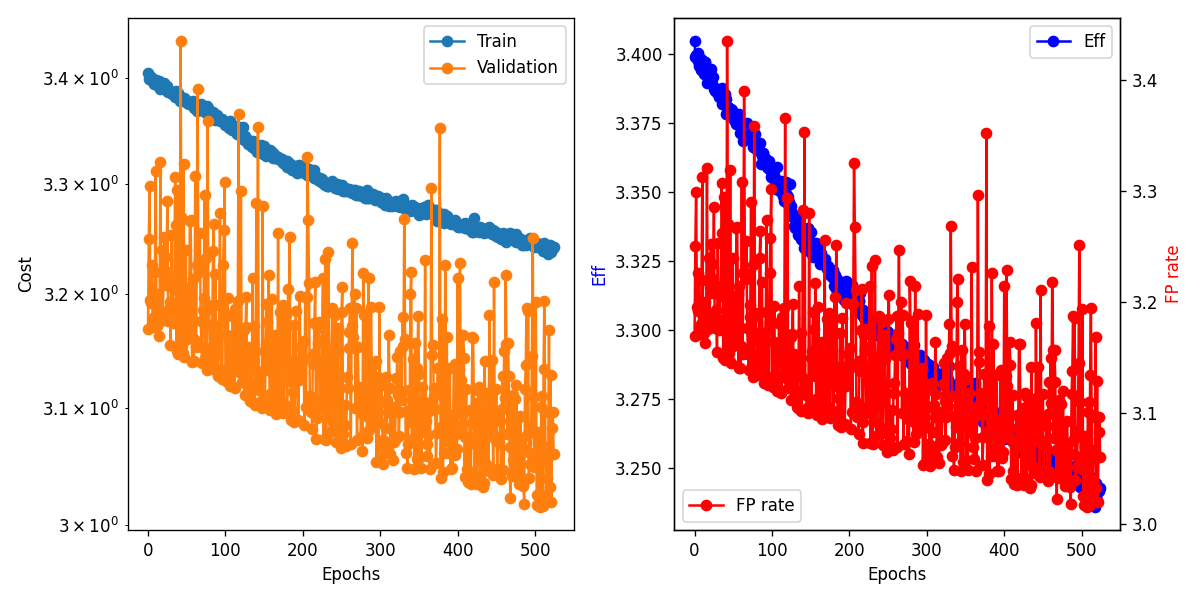

In [21]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [23]:
quit()